In [1]:
import cudf
from dask_cuda import LocalCUDACluster
import distributed
import dask_cudf
import dask
import dask.dataframe as dd
import os

In [2]:
import sys
sys.executable

'/home/ericdill/miniconda/envs/rapids-nightly/bin/python'

In [3]:
# cluster = LocalCUDACluster()

# client = distributed.Client(cluster)

In [4]:
partitioned_base = '/mnt/storage/anaconda-parsed-logs-partitioned'

In [5]:
def to_fname(ymd):
    year, month, day = ymd.split('-')
    return f'{partitioned_base}/{year}/{month}/{year}-{month}-{day}.parquet'

In [6]:
fname = to_fname('2017-01-01')
fname

'/mnt/storage/anaconda-parsed-logs-partitioned/2017/01/2017-01-01.parquet'

In [7]:
# partitioned_fname = f'/mnt/storage/parsed-logs-partitioned/{year}/{month}/{year}-{month}-{day}.parquet'
# os.makedirs(os.path.dirname(partitioned_fname), exist_ok=True)

In [ ]:
df = cudf.read_parquet(fname + "/*").reset_index()
df.head()

In [7]:
df = dask_cudf.read_parquet(fname).reset_index()
df.head()

,timestamp,bytes,city,continent,country,domain_name,full_user_agent,ip,label,latitude,...,pkg_python,pkg_version,postal_code,rayid,source,uri,user_agent,user_agent_version,user_platform,user_platform_version
0,2019-09-01 00:00:00.072,452325,Ann Arbor,North America,United States,65.237.35.bc.googleusercontent.com,conda/4.5.4 requests/2.18.4 CPython/3.6.5 Linu...,35.237.65.0,,42.2734,...,,8.0,48104,50f2f6207888ba4c,cloudflare_anaconda,/conda-forge/linux-64/readline-8.0-hf8c457e_0....,Conda,4.5.4,Linux,4.9.0-9-amd64
1,2019-09-01 00:00:00.118,7165775,Grove City,North America,United States,zoominternet.net,conda/4.5.12 requests/2.21.0 CPython/3.7.1 Win...,24.144.174.0,None,41.1660,...,37,3.2.1,16127,50f2f620bb44a403,cloudflare_repo_anaconda,/pkgs/main/win-64/astropy-3.2.1-py37he774522_0...,Conda,4.5.12,Windows,10
2,2019-09-01 00:00:00.164,4213278,Bergen,Europe,Norway,bb.online.no,conda/4.3.34 requests/2.19.1 CPython/2.7.13 Li...,88.91.183.0,None,60.3266,...,27,2.3.2,5152,50f2f6210824428f,cloudflare_repo_anaconda,/pkgs/free/linux-64/spyder-2.3.2-py27_0.tar.bz2,Conda,4.3.34,Linux,3.10.0-957.27.2.el7.x86_64
3,2019-09-01 00:00:00.173,6114,Barcelona,Europe,Spain,bsc.es,Mozilla,84.88.52.0,,41.3888,...,,1.16.0,08034,50f2f6211ddf614f,cloudflare_anaconda,/bioconda/bioconductor-mirsynergy/1.16.0/downl...,Mozilla,,,
4,2019-09-01 00:00:00.224,6168,Barcelona,Europe,Spain,bsc.es,Mozilla,84.88.52.0,,41.3888,...,,1.40.0,08034,50f2f6216a776161,cloudflare_anaconda,/bioconda/bioconductor-genoset/1.40.0/download...,Mozilla,,,


In [8]:
df.to_parquet('out.parquet')

ValueError: cannot infer type for <class 'NoneType'>

In [31]:
!rm -r ./tmp.parquet/

In [32]:
cols = ['timestamp']
#cols = df.columns
df[cols].head().to_parquet('tmp.parquet')

In [9]:
import dask_cudf
import cudf
import pandas as pd

In [20]:
output_file = 'timestamp.parquet'
output_dir = 'ts.parquet'

In [31]:
# Clean up before the demo here
!rm {output_dir} -r
!rm {output_file}

rm: cannot remove ‘ts.parquet’: No such file or directory
rm: cannot remove ‘timestamp.parquet’: No such file or directory


In [35]:
df = pd.DataFrame({'timestamp': pd.datetime(2019, 10, 21)}, index=[1])
df

,timestamp
1,2019-10-21


In [36]:
# Use pandas to write a parquet file
df.to_parquet('timestamp.parquet')

In [37]:
# Use cudf to read the parquet file. This works fine
df = cudf.read_parquet(output_file)
df.dtypes

timestamp    datetime64[ms]
dtype: object

In [38]:
df

,timestamp
1,2019-10-21


In [39]:
# Try and write a parquet file using the cudf dataframe. Get an error because the cudf implementation seems to 
# be trying to write a directory with a partition inside of it. I would expect this to try and write a file called 
# "timestamp.parquet"
df.to_parquet(output_file)

NotADirectoryError: [Errno 20] Not a directory: 'timestamp.parquet/af675ffeff9f49f4a0ef994ec5fad332.parquet'

In [40]:
# Let's now make that directory so that cudf can write
!mkdir {output_dir}

In [41]:
# Now if we save to the directory, it seems to be outputting correctly
df.to_parquet(output_dir)

In [42]:
!ls {output_dir}

dff6a8aa53da4eed95ebcbe4aba6a071.parquet


In [43]:
# Let's write to that directory again
df.to_parquet(output_dir)

In [44]:
!ls {output_dir}

3dde20b2e6c04fd495c825a737f492c1.parquet
dff6a8aa53da4eed95ebcbe4aba6a071.parquet


In [45]:
# Seems as though we're writing a new parquet file out each time we call to_parquet. This is somewhat unintuitive.
# The to_parquet docs don't seem to suggest anything here either.
df.to_parquet??

Signature: df.to_parquet(path, *args, **kwargs)
Docstring:
Write a DataFrame to the parquet format.

Parameters
----------
path : str
    File path or Root Directory path. Will be used as Root Directory path
    while writing a partitioned dataset.
compression : {'snappy', 'gzip', 'brotli', None}, default 'snappy'
    Name of the compression to use. Use ``None`` for no compression.
index : bool, default None
    If ``True``, include the dataframe's index(es) in the file output. If
    ``False``, they will not be written to the file. If ``None``, the
    engine's default behavior will be used.
partition_cols : list, optional, default None
    Column names by which to partition the dataset
    Columns are partitioned in the order they are given

See Also
--------
cudf.io.parquet.read_parquet
cudf.io.orc.read_orc
Source:   
    @ioutils.doc_to_parquet()
    def to_parquet(self, path, *args, **kwargs):
        """{docstring}"""
        import cudf.io.parquet as pq

        pq.to_parquet(se

# Read in with cudf

In [47]:
# Seems that you can't read in that directory though
df = cudf.read_parquet(output_dir)
df

FileNotFoundError: [Errno 2] No such file or directory: '/home/ericdill/dev/pydatanyc2019/RAPIDS/notebooks/ts.parquet'

In [48]:
# Need to remind myself what output_dir is here
output_dir

'ts.parquet'

In [51]:
# Let's try and make it obviously a directory
cudf.read_parquet(f'{output_dir}/')

FileNotFoundError: [Errno 2] No such file or directory: '/home/ericdill/dev/pydatanyc2019/RAPIDS/notebooks/ts.parquet'

In [54]:
# Ah that's the right syntax. Need to tell it to read all files in that dir
cudf.read_parquet(f'{output_dir}/*')

,timestamp
1,2019-10-21


In [55]:
# Though if you do read it in with pandas, things seem to work just fine, but now we have two rows instead of the one
pd.read_parquet(output_dir)

,timestamp
1,2019-10-21
1,2019-10-21


# Read in with dask_cudf

In [58]:
# Reading in with dask_cudf seems to work if we just pass it in a directory path. no need for the extra /* like with
# cudf, though in this case we get a TypeError because it seems to not understand how to handle a datetime64[ns] dtype
dask_cudf.read_parquet(output_dir)

TypeError: cannot convert datetimelike to dtype [datetime64[ms]]

In [59]:
# we get the same error no matter how we try and read these files in
dask_cudf.read_parquet(f'{output_dir}/')

TypeError: cannot convert datetimelike to dtype [datetime64[ms]]

In [60]:
# we get the same error no matter how we try and read these files in
dask_cudf.read_parquet(f'{output_dir}/*')

TypeError: cannot convert datetimelike to dtype [datetime64[ms]]

In [8]:
df = dask_cudf.read_parquet('tmp.parquet')
df.dtypes

TypeError: cannot convert datetimelike to dtype [datetime64[us]]

In [29]:
df.repartition(npartitions=npartitions).to_parquet(partitioned_fname)

NameError: name 'npartitions' is not defined

In [10]:
df.dtypes

bytes                      int64
city                      object
continent                 object
country                   object
domain_name               object
full_user_agent           object
ip                        object
label                     object
latitude                 float64
longitude                float64
pkg_arch                  object
pkg_branch                object
pkg_channel               object
pkg_name                  object
pkg_numpy                 object
pkg_platform              object
pkg_python                object
pkg_version               object
postal_code               object
rayid                     object
source                    object
uri                       object
user_agent                object
user_agent_version        object
user_platform             object
user_platform_version     object
dtype: object

In [26]:
import pandas as pd

In [30]:
pd.read_parquet(fname, engine='pyarrow', )

ArrowIOError: Unexpected end of stream: Page was smaller (2865924) than expected (2872975)

In [29]:
!conda list pyarrow -n rapids-nightly

# packages in environment at /home/ericdill/miniconda/envs/rapids-nightly:
#
# Name                    Version                   Build  Channel
pyarrow                   0.14.1           py37h8b68381_2    conda-forge


In [28]:
from pyarrow.parquet import read_table
read_table(fname)

ArrowIOError: Unexpected end of stream: Page was smaller (2865924) than expected (2872975)

In [22]:
from fastparquet import ParquetFile
pf = ParquetFile('myfile.parq')


ModuleNotFoundError: No module named 'fastparquet'

In [21]:
dask_cudf.read_parquet(fname).dtypes

bytes                             int64
city                     datetime64[ns]
continent                datetime64[ns]
country                  datetime64[ns]
domain_name                      object
full_user_agent                  object
ip                               object
label                    datetime64[ns]
latitude                        float64
longitude                       float64
pkg_arch                 datetime64[ns]
pkg_branch               datetime64[ns]
pkg_channel              datetime64[ns]
pkg_name                 datetime64[ns]
pkg_numpy                datetime64[ns]
pkg_platform             datetime64[ns]
pkg_python               datetime64[ns]
pkg_version              datetime64[ns]
postal_code              datetime64[ns]
rayid                            object
source                   datetime64[ns]
uri                      datetime64[ns]
user_agent               datetime64[ns]
user_agent_version       datetime64[ns]
user_platform            datetime64[ns]


In [11]:
df = dask_cudf.read_parquet(partitioned_fname)

In [20]:
df.dtypes

bytes                             int64
city                     datetime64[ns]
continent                datetime64[ns]
country                  datetime64[ns]
domain_name                      object
full_user_agent                  object
ip                               object
label                    datetime64[ns]
latitude                        float64
longitude                       float64
pkg_arch                 datetime64[ns]
pkg_branch               datetime64[ns]
pkg_channel              datetime64[ns]
pkg_name                 datetime64[ns]
pkg_numpy                datetime64[ns]
pkg_platform             datetime64[ns]
pkg_python               datetime64[ns]
pkg_version              datetime64[ns]
postal_code              datetime64[ns]
rayid                            object
source                   datetime64[ns]
uri                      datetime64[ns]
user_agent               datetime64[ns]
user_agent_version       datetime64[ns]
user_platform            datetime64[ns]


In [12]:
df.head()

,bytes,city,continent,country,domain_name,full_user_agent,ip,label,latitude,longitude,...,pkg_python,pkg_version,postal_code,rayid,source,uri,user_agent,user_agent_version,user_platform,user_platform_version
timestamp,,,,,,,,,,,,,,,,,,,,,
2019-09-01 00:00:00.072,452325,Ann Arbor,North America,United States,65.237.35.bc.googleusercontent.com,conda/4.5.4 requests/2.18.4 CPython/3.6.5 Linu...,35.237.65.0,,42.2734,-83.7133,...,,8.0,48104,50f2f6207888ba4c,cloudflare_anaconda,/conda-forge/linux-64/readline-8.0-hf8c457e_0....,Conda,4.5.4,Linux,4.9.0-9-amd64
2019-09-01 00:00:00.118,7165775,Grove City,North America,United States,zoominternet.net,conda/4.5.12 requests/2.21.0 CPython/3.7.1 Win...,24.144.174.0,None,41.1660,-80.0615,...,37,3.2.1,16127,50f2f620bb44a403,cloudflare_repo_anaconda,/pkgs/main/win-64/astropy-3.2.1-py37he774522_0...,Conda,4.5.12,Windows,10
2019-09-01 00:00:00.164,4213278,Bergen,Europe,Norway,bb.online.no,conda/4.3.34 requests/2.19.1 CPython/2.7.13 Li...,88.91.183.0,None,60.3266,5.3024,...,27,2.3.2,5152,50f2f6210824428f,cloudflare_repo_anaconda,/pkgs/free/linux-64/spyder-2.3.2-py27_0.tar.bz2,Conda,4.3.34,Linux,3.10.0-957.27.2.el7.x86_64
2019-09-01 00:00:00.173,6114,Barcelona,Europe,Spain,bsc.es,Mozilla,84.88.52.0,,41.3888,2.1590,...,,1.16.0,08034,50f2f6211ddf614f,cloudflare_anaconda,/bioconda/bioconductor-mirsynergy/1.16.0/downl...,Mozilla,,,
2019-09-01 00:00:00.224,6168,Barcelona,Europe,Spain,bsc.es,Mozilla,84.88.52.0,,41.3888,2.1590,...,,1.40.0,08034,50f2f6216a776161,cloudflare_anaconda,/bioconda/bioconductor-genoset/1.40.0/download...,Mozilla,,,


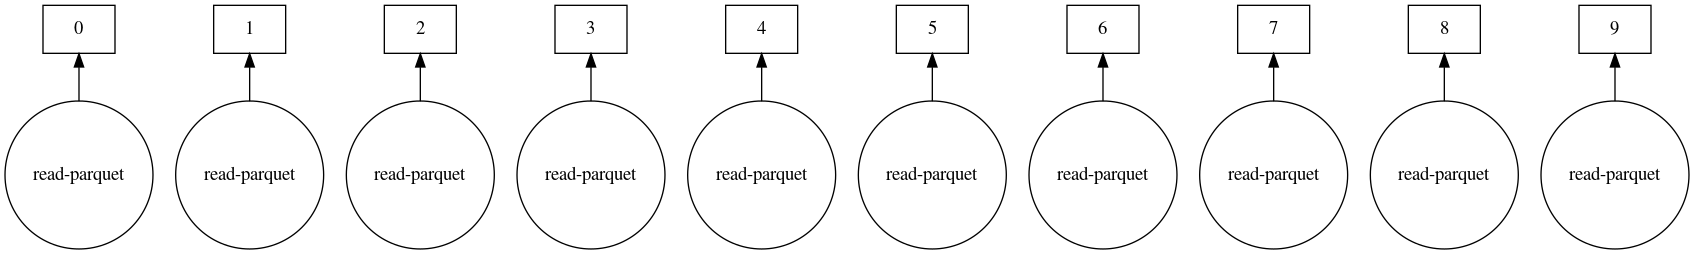

In [13]:
dask.visualize(df)

In [66]:
# can't do this on cudf yet
# https://github.com/rapidsai/cudf/issues/2793
#raw_data['time']= raw_data['timestamp'].map(lambda t: t.replace(minute=0, second=0, microsecond=0))


In [14]:
raw_data = df
raw_data = raw_data.reset_index()
raw_data = raw_data[
    (raw_data.source.isin(['cloudflare_conda','cloudflare_repo_anaconda']))|
    (raw_data.pkg_channel.isin(['conda-forge','bioconda','pyviz']))]
c = raw_data.head()

In [15]:
c

,timestamp,bytes,city,continent,country,domain_name,full_user_agent,ip,label,latitude,...,pkg_python,pkg_version,postal_code,rayid,source,uri,user_agent,user_agent_version,user_platform,user_platform_version
0,2019-09-01 00:00:00.072,452325,Ann Arbor,North America,United States,65.237.35.bc.googleusercontent.com,conda/4.5.4 requests/2.18.4 CPython/3.6.5 Linu...,35.237.65.0,,42.2734,...,,8.0,48104,50f2f6207888ba4c,cloudflare_anaconda,/conda-forge/linux-64/readline-8.0-hf8c457e_0....,Conda,4.5.4,Linux,4.9.0-9-amd64
1,2019-09-01 00:00:00.118,7165775,Grove City,North America,United States,zoominternet.net,conda/4.5.12 requests/2.21.0 CPython/3.7.1 Win...,24.144.174.0,None,41.1660,...,37,3.2.1,16127,50f2f620bb44a403,cloudflare_repo_anaconda,/pkgs/main/win-64/astropy-3.2.1-py37he774522_0...,Conda,4.5.12,Windows,10
2,2019-09-01 00:00:00.164,4213278,Bergen,Europe,Norway,bb.online.no,conda/4.3.34 requests/2.19.1 CPython/2.7.13 Li...,88.91.183.0,None,60.3266,...,27,2.3.2,5152,50f2f6210824428f,cloudflare_repo_anaconda,/pkgs/free/linux-64/spyder-2.3.2-py27_0.tar.bz2,Conda,4.3.34,Linux,3.10.0-957.27.2.el7.x86_64
3,2019-09-01 00:00:00.173,6114,Barcelona,Europe,Spain,bsc.es,Mozilla,84.88.52.0,,41.3888,...,,1.16.0,08034,50f2f6211ddf614f,cloudflare_anaconda,/bioconda/bioconductor-mirsynergy/1.16.0/downl...,Mozilla,,,
4,2019-09-01 00:00:00.224,6168,Barcelona,Europe,Spain,bsc.es,Mozilla,84.88.52.0,,41.3888,...,,1.40.0,08034,50f2f6216a776161,cloudflare_anaconda,/bioconda/bioconductor-genoset/1.40.0/download...,Mozilla,,,


In [16]:
raw_data.pkg_channel.unique().compute()

0           None
1       bioconda
2    conda-forge
3          pyviz
Name: pkg_channel, dtype: object

In [19]:
raw_data.dtypes

timestamp                datetime64[ns]
bytes                             int64
city                     datetime64[ns]
continent                datetime64[ns]
country                  datetime64[ns]
domain_name                      object
full_user_agent                  object
ip                               object
label                    datetime64[ns]
latitude                        float64
longitude                       float64
pkg_arch                 datetime64[ns]
pkg_branch               datetime64[ns]
pkg_channel              datetime64[ns]
pkg_name                 datetime64[ns]
pkg_numpy                datetime64[ns]
pkg_platform             datetime64[ns]
pkg_python               datetime64[ns]
pkg_version              datetime64[ns]
postal_code              datetime64[ns]
rayid                            object
source                   datetime64[ns]
uri                      datetime64[ns]
user_agent               datetime64[ns]
user_agent_version       datetime64[ns]


In [17]:
raw_data.pkg_channel.where(
    raw_data.pkg_channel.isin(['conda-forge', 'bioconda','pyviz']), 'anaconda')

ValueError: Metadata inference failed in `where`.

You have supplied a custom function and Dask is unable to 
determine the type of output that that function returns. 

To resolve this please provide a meta= keyword.
The docstring of the Dask function you ran should have more information.

Original error is below:
------------------------
ValueError('Error parsing datetime string "anaconda" at position 0')

Traceback:
---------
  File "/home/ericdill/miniconda/envs/rapids-nightly/lib/python3.7/site-packages/dask/dataframe/utils.py", line 168, in raise_on_meta_error
    yield
  File "/home/ericdill/miniconda/envs/rapids-nightly/lib/python3.7/site-packages/dask/dataframe/core.py", line 4725, in _emulate
    return func(*_extract_meta(args, True), **_extract_meta(kwargs, True))
  File "/home/ericdill/miniconda/envs/rapids-nightly/lib/python3.7/site-packages/dask/utils.py", line 876, in __call__
    return getattr(obj, self.method)(*args, **kwargs)
  File "/home/ericdill/miniconda/envs/rapids-nightly/lib/python3.7/site-packages/cudf/core/series.py", line 1248, in where
    other, (len(to_replace),), np.dtype(typ)
  File "/home/ericdill/miniconda/envs/rapids-nightly/lib/python3.7/site-packages/cudf/utils/utils.py", line 84, in scalar_broadcast_to
    scalar = to_cudf_compatible_scalar(scalar, dtype=dtype)
  File "/home/ericdill/miniconda/envs/rapids-nightly/lib/python3.7/site-packages/cudf/utils/dtypes.py", line 155, in to_cudf_compatible_scalar
    val = val.astype(dtype)


In [56]:
raw_data.pkg_channel.isin(['conda-forge', 'bioconda','pyviz'])

In [54]:
raw_data['data_source'] = raw_data.pkg_channel.where(
    raw_data.pkg_channel.isin(['conda-forge', 'bioconda','pyviz']), 'anaconda')

ValueError: Metadata inference failed in `where`.

You have supplied a custom function and Dask is unable to 
determine the type of output that that function returns. 

To resolve this please provide a meta= keyword.
The docstring of the Dask function you ran should have more information.

Original error is below:
------------------------
RuntimeError('cuDF failure at: /conda/conda-bld/libcudf_1571385185316/work/cpp/src/join/joining.cu:204: DTYPE mismatch')

Traceback:
---------
  File "/home/ericdill/miniconda/envs/rapids-nightly/lib/python3.7/site-packages/dask/dataframe/utils.py", line 168, in raise_on_meta_error
    yield
  File "/home/ericdill/miniconda/envs/rapids-nightly/lib/python3.7/site-packages/dask/dataframe/core.py", line 4725, in _emulate
    return func(*_extract_meta(args, True), **_extract_meta(kwargs, True))
  File "/home/ericdill/miniconda/envs/rapids-nightly/lib/python3.7/site-packages/dask/utils.py", line 876, in __call__
    return getattr(obj, self.method)(*args, **kwargs)
  File "/home/ericdill/miniconda/envs/rapids-nightly/lib/python3.7/site-packages/cudf/core/series.py", line 1236, in where
    to_replace = self._column.apply_boolean_mask(~cond & self.notna())
  File "/home/ericdill/miniconda/envs/rapids-nightly/lib/python3.7/site-packages/cudf/core/series.py", line 907, in __and__
    return self._bitwise_binop(other, "and")
  File "/home/ericdill/miniconda/envs/rapids-nightly/lib/python3.7/site-packages/cudf/core/series.py", line 891, in _bitwise_binop
    ser = self._binaryop(other, op)
  File "/home/ericdill/miniconda/envs/rapids-nightly/lib/python3.7/site-packages/cudf/core/series.py", line 596, in _binaryop
    lhs, rhs = _align_indices(self, other)
  File "/home/ericdill/miniconda/envs/rapids-nightly/lib/python3.7/site-packages/cudf/core/series.py", line 2622, in _align_indices
    lhs, rhs = lhs.join(rhs, how=join, sort=True)._cols.values()
  File "/home/ericdill/miniconda/envs/rapids-nightly/lib/python3.7/site-packages/cudf/core/dataframe.py", line 2532, in join
    method=method,
  File "/home/ericdill/miniconda/envs/rapids-nightly/lib/python3.7/site-packages/cudf/core/dataframe.py", line 2301, in merge
    lhs._cols, rhs._cols, left_on, right_on, how, method
  File "cudf/_lib/join.pyx", line 21, in cudf._lib.join.join
  File "cudf/_lib/join.pyx", line 99, in cudf._lib.join.join


In [5]:
from functools import partial

In [6]:
base = '/mnt/storage/anaconda-parsed-logs/'

def to_file(base, datestring):
    year, month, day = datestring.split('-')
    fname = f'{base}/{year}/{month}/{datestring}.parquet'
    return fname

to_file = partial(to_file, base)
first = to_file('2016-10-28')
last = to_file('2019-09-02')

In [7]:
first

'/mnt/storage/anaconda-parsed-logs//2016/10/2016-10-28.parquet'

In [8]:
df_first = dask_cudf.read_parquet(first)

In [9]:
df_last = dask_cudf.read_parquet(first)

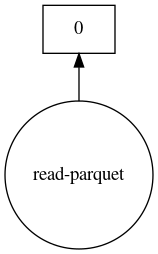

In [10]:
df_last.visualize()